## Author: Ahmed Mostafa
## Id: 1772729

In [98]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# 1.1

# Setting up the graph

In [99]:
g = nx.barabasi_albert_graph(6000, 2)

## Plotting the graph degree distribution

the plot shows that power law applies to the graph 

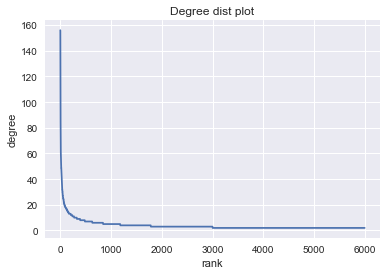

In [100]:
degree_sequence=sorted(nx.degree(g).values(),reverse=True) 
plt.plot(degree_sequence)
plt.title("Degree dist plot")
plt.ylabel("degree")
plt.xlabel("rank")

# 1.2

## Simple class to simulate an SIR process on a graph

In [101]:
class SIRSimulator:
    def __init__(self, graph, beta=0.25, mu=0.05):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        
    def run(self, seed=[], num_steps=1):
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(self.g.nodes()) ]
            
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(self.g.neighbors(i)):
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1

# 1.3 

## Set up simulation

In [102]:
M = 10 #number of simulations 
overall_attack_rate = []
peaktime = []

Running multiple stochastic realizations, plotting their `epidemic curves`, and calculating `overall attack rate` and `peak time`

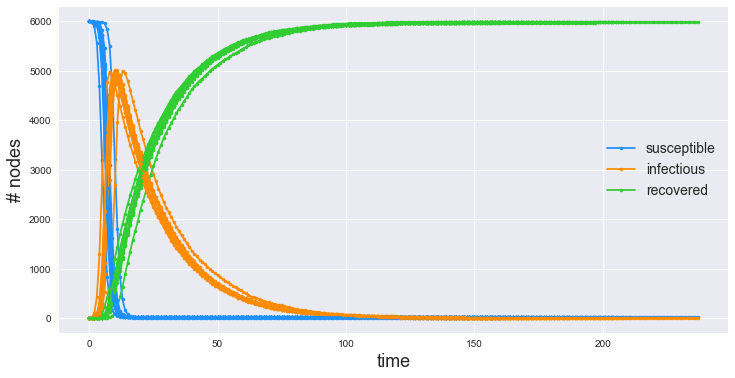

In [103]:
plt.figure(figsize=(12,6))
for _ in range(M):
    SIR = SIRSimulator(g, beta=0.4, mu=0.05)
    status = [ (len(status['R']),(len(status['I']), status['t']),len(status['S'])) for status in SIR.run()]
    R = []
    I_T = []
    I = []
    T = []
    S = []
    for row in status:
        R.append(row[0])
        I_T.append(row[1])
        I.append(row[1][0])
        T.append(row[1][1])
        S.append(row[2])
    overall_attack_rate.append(R[-1])
    peaktime.append(max(I_T)[1])
    SIR = SIRSimulator(g, beta=0.4, mu=0.05)
    plt.plot(S, '.-', color = 'dodgerblue')
    plt.plot(I, '.-', color = 'darkorange')
    plt.plot(R, '.-', color = 'limegreen')
   # plt.plot([ (len(status['S']), len(status['I']),len(status['R'])) for status in SIR.run()], '.-')
    plt.xlabel('time', fontsize=18)
    plt.ylabel('# nodes', fontsize=18)
    plt.legend(['susceptible', 'infectious', 'recovered'], fontsize=14, loc=7)

Plotting overall attack rate

<function matplotlib.pyplot.show>

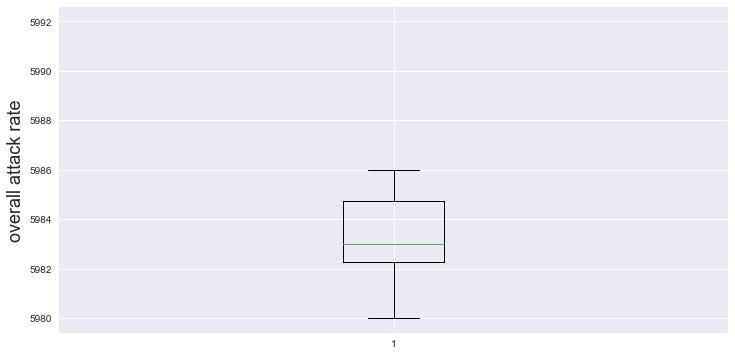

In [104]:
plt.figure(figsize=(12,6))
plt.boxplot(overall_attack_rate)
plt.ylabel('overall attack rate', fontsize=18)
plt.show

<function matplotlib.pyplot.show>

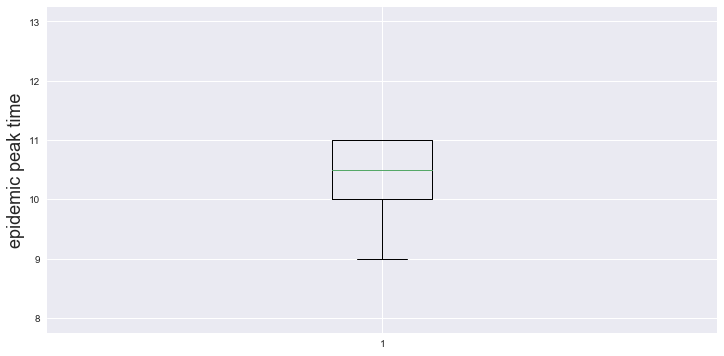

In [105]:
plt.figure(figsize=(12,6))
plt.boxplot(peaktime)  
plt.ylabel('epidemic peak time', fontsize=18)
plt.show

# 2.1
## Updating SIR simulation
Updating SIR simulation to take immunization factor and immunize nodes randomly selected 

In [106]:
class SIRSimulator:
    def __init__(self, graph, beta=0.25, mu=0.05, immunization_factor = 0.0):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        self.immunization_factor = immunization_factor
    def run(self, seed=[], num_steps=1):

        # Randomly uniformally choosing the immunized nodes
        immunized = set(np.random.choice(self.g.nodes(), size = int(g.number_of_nodes()*self.immunization_factor) ))

        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(list(set(self.g.nodes()).difference(immunized))) ] # removing the immunized nodes from the seed
        
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(self.g.neighbors(i)):
                    if j in immunized: # if immunized, then it cannot get infected
                        continue
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1

Without simulation we can only tell that the upper bound of the inficted nodes = total nodes - number of immunized nodes 
Simulation will give us a better estimation of this upper bound

# 2.2
## Plotting overall attack rate for multiple realizations for different fractions

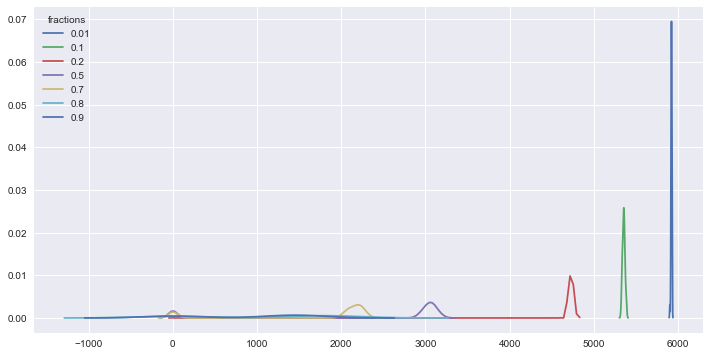

In [107]:
M = 50 #number of simulations 
fractions = [0.01, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9]
plt.figure(figsize=(12,6))
import seaborn as sns
for r in fractions:
    overall_attack_rate = []
    for _ in range(M):
        SIR = SIRSimulator(g, beta=0.4, mu=0.05,immunization_factor=r)
        R = [ (len(status['R'])) for status in SIR.run()]
        overall_attack_rate.append(R[-1])
    sns.distplot(overall_attack_rate,hist=False,label=r)
    plt.legend(title="fractions")

# 2.3
## Using a random Erdős–Rényi graph 

In [108]:
g_er = nx.erdos_renyi_graph(6000, nx.density(g))

Plotting the fitted distribution of the overall attack rate in case of Erdős–Rényi graph 
Comparing to the plotted overall attack rate of BA graphs - which leads to similar distributions 

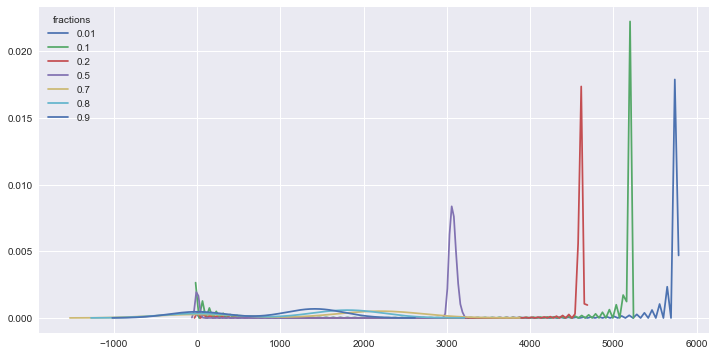

In [110]:
plt.figure(figsize=(12,6))
import seaborn as sns
for r in fractions:
    overall_attack_rate = []
    for _ in range(M):
        SIR = SIRSimulator(g_er, beta=0.4, mu=0.05,immunization_factor=r)
        R = [ (len(status['R'])) for status in SIR.run()]
        overall_attack_rate.append(R[-1])
    sns.distplot(overall_attack_rate,hist=False,label=r)
    plt.legend(title="fractions")

# 3.1
# Updating the simulation to take predefined set of immunized nodes

In [111]:
class SIRSimulator:
    def __init__(self, graph, beta=0.25, mu=0.05, immunization_factor = 0.0,immunization_nodes=[]):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        self.immunization_factor = immunization_factor
        self.immunization_nodes = immunization_nodes

    def run(self, seed=[], num_steps=1):

        if len(self.immunization_nodes) != 0:
            immunized = self.immunization_nodes
        else:
            # Randomly uniformally choosing the immunized nodes
            immunized = set(np.random.choice(self.g.nodes(), size = int(g.number_of_nodes()*self.immunization_factor) ))

        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(list(set(self.g.nodes()).difference(immunized))) ] # removing the immunized nodes from the seed
        
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
               # print(I_set)
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(self.g.neighbors(i)):
                    if j in immunized: # if immunized, then it cannot get infected
                        continue
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1

## Developing a strategy to select which nodes to vaccinate
We will vaccinate the nodes with the highest `betweenness centrality` 

In [112]:
betweenness_cent_dict = nx.betweenness_centrality(g) # calculating betweenness centrality

choosing the M nodes with the highest betweenness_centrality   

In [113]:
M = 100 # number of vaccines available 
maxBC_nodes = []
for _ in range(M):
    maxBC = max(betweenness_cent_dict.values())
    maxBC_node = [key for key in betweenness_cent_dict.keys() if betweenness_cent_dict[key]==maxBC][0]
    maxBC_nodes.append(maxBC_node)
    betweenness_cent_dict.pop(maxBC_node)
print("nodes to immunize:")
print(maxBC_nodes)

nodes to immunize:
[9, 7, 1, 2, 6, 8, 10, 33, 16, 0, 12, 40, 4, 41, 81, 11, 37, 18, 61, 45, 5, 27, 51, 23, 57, 15, 87, 19, 29, 38, 71, 44, 13, 225, 135, 67, 166, 36, 77, 114, 42, 282, 165, 127, 28, 63, 117, 169, 181, 83, 62, 265, 26, 172, 187, 121, 142, 357, 112, 32, 167, 17, 204, 359, 99, 118, 432, 148, 133, 50, 145, 128, 149, 150, 376, 60, 319, 103, 242, 72, 248, 190, 107, 73, 30, 383, 310, 46, 153, 22, 24, 257, 106, 665, 86, 143, 91, 104, 3, 79]


## Comparing the developed strategy with the random vaccination
Simulating epidemic with 1) immunizing randomly of fraciton = M/N 2) using the strategy 

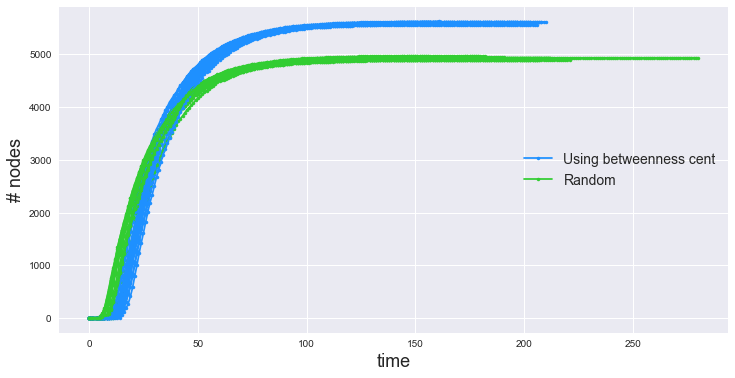

In [114]:
plt.figure(figsize=(12,6))
for _ in range(20):
    SIR_strategy = SIRSimulator(g, beta=0.4, mu=0.05, immunization_nodes=maxBC_nodes)
    SIR_random = SIRSimulator(g, beta=0.4, mu=0.05,immunization_factor=M/600)

    R_strategy  = [ (len(status['R'])) for status in SIR_strategy.run()]
    R_random  = [ (len(status['R'])) for status in SIR_random.run()]
    plt.plot(R_strategy, '.-', color = 'dodgerblue')
    plt.plot(R_random, '.-', color = 'limegreen')
    plt.xlabel('time', fontsize=18)
    plt.ylabel('# nodes', fontsize=18)
    plt.legend(['Using betweenness cent', 'Random'], fontsize=14, loc=7)

# 3.2
## Developing the strategy without knowledge of the graph 
We will choose the nodes that are the earlist to be inficted \n
We simulate multiple eipedmics on the graph, calculate the average time for each node to be inficted, select the M nodes with minimum average infiction time and vaccinate them. 

In [115]:
SIR = SIRSimulator(g, beta=0.4, mu=0.05)
ItoTArr = {}
for _ in range(10):
    StoI  = [ status['S->I'] for status in SIR.run()]
    for t in range(len(StoI)):
        for i in StoI[t]:
            if i not in ItoTArr:
                ItoTArr[i] = []
            ItoTArr[i].append(t)
ItoTAvg = {} # containes the average time of infection per node
for i in ItoTArr:
    avg = np.mean(ItoTArr[i])
    ItoTAvg[i] = avg

In [116]:
M = 100 #number of nodes to be immunized
minInfictionTime_nodes = []
for _ in range(M):
    minTime = min(ItoTAvg.values())
    minTime_node = [key for key in ItoTAvg.keys() if ItoTAvg[key]==minTime][0]
    minInfictionTime_nodes.append(minTime_node)
    ItoTAvg.pop(minTime_node)

In [117]:
print("nodes to be vaccinated")
print(minInfictionTime_nodes)

nodes to be vaccinated
[9, 7, 2, 8, 61, 1, 33, 37, 166, 4, 12, 40, 0, 16, 45, 10, 19, 5, 27, 6, 77, 149, 1345, 36, 135, 266, 167, 13, 81, 3, 26, 29, 34, 47, 11, 432, 91, 57, 103, 133, 182, 335, 248, 470, 5495, 206, 122, 888, 51, 76, 145, 163, 1244, 1254, 23, 44, 185, 242, 459, 993, 41, 111, 62, 73, 171, 3160, 38, 71, 86, 190, 283, 311, 4919, 3287, 325, 1952, 5635, 154, 210, 5059, 20, 24, 42, 83, 99, 117, 143, 181, 189, 201, 4484, 446, 454, 728, 954, 1128, 3974, 15, 22, 90]


Comparing the new developed stragey to the previous vaccination techniques. 

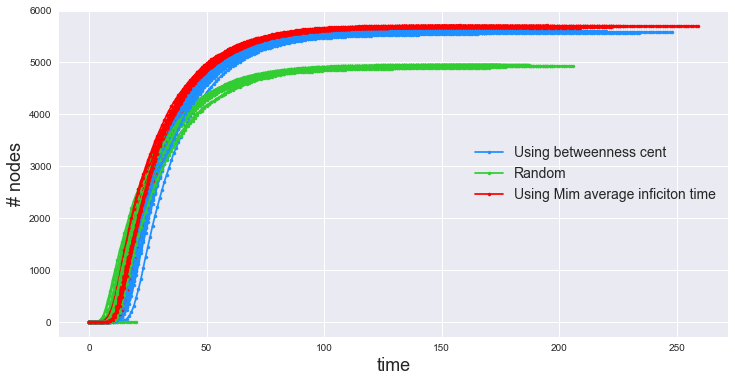

In [118]:
plt.figure(figsize=(12,6))
for _ in range(20):
    SIR_strategy_betweenness_cent = SIRSimulator(g, beta=0.4, mu=0.05, immunization_nodes=maxBC_nodes)
    SIR_random = SIRSimulator(g, beta=0.4, mu=0.05,immunization_factor=M/600)
    SIR_strategy_time = SIRSimulator(g, beta=0.4, mu=0.05, immunization_nodes=minInfictionTime_nodes)

    R_strategy_betweenness_cent  = [ (len(status['R'])) for status in SIR_strategy_betweenness_cent.run()]
    R_random  = [ (len(status['R'])) for status in SIR_random.run()]
    R_strategy_time  = [ (len(status['R'])) for status in SIR_strategy_time.run()]

    plt.plot(R_strategy_betweenness_cent, '.-', color = 'dodgerblue')
    plt.plot(R_random, '.-', color = 'limegreen')
    plt.plot(R_strategy_time, '.-', color = 'red')

    plt.xlabel('time', fontsize=18)
    plt.ylabel('# nodes', fontsize=18)
    plt.legend(['Using betweenness cent', 'Random','Using Mim average inficiton time'], fontsize=14, loc=7)

# 3.3
## With only knowledge of part of the graph 

In [119]:
# selecting random nodes from the graph g 
subGraphSize = 200
subGraphNodes = set(np.random.choice(g.nodes(), size = subGraphSize ))

now we only know the nodes and their neighbors -
we are going to use the nodes degree to priotrize their immuzation 

In [120]:
# now we only know the nodes and their neighbors 
# we are going to use the nodes degree to priotrize their immuzation 
nodesToDegree = {}
for node in subGraphNodes:
    nodesToDegree[node] = g.degree(node)

M = 100 #number of to be immunized
maxDegree_nodes = []
for _ in range(M):
    maxDegree = min(nodesToDegree.values())
    maxDegree_node = [key for key in nodesToDegree.keys() if nodesToDegree[key]==maxDegree][0]
    maxDegree_nodes.append(maxDegree_node)
    nodesToDegree.pop(maxDegree_node)
print("Nodes to vaccinate")
print(maxDegree_nodes)

Nodes to vaccinate
[2565, 5128, 5642, 4113, 5651, 5656, 4125, 5150, 4646, 4135, 4655, 3634, 3125, 4664, 2113, 3654, 2133, 5717, 1112, 5724, 2658, 3189, 5752, 4741, 2183, 2698, 2717, 2718, 5791, 676, 5286, 2730, 3242, 1718, 4793, 3256, 5314, 1732, 3784, 1226, 5322, 5835, 4314, 2795, 5873, 4852, 4857, 3834, 1793, 1794, 1283, 3336, 3337, 5388, 2323, 5907, 5397, 4373, 5914, 2332, 4904, 4910, 2363, 3904, 1346, 4416, 5962, 5964, 4428, 846, 5969, 5457, 5460, 4443, 4956, 3429, 3941, 1892, 4972, 3456, 2948, 3474, 3992, 5016, 4506, 5018, 4512, 1954, 3499, 5037, 4018, 5565, 3009, 5082, 3039, 4577, 5098, 5102, 5108, 2549]


Comparing this technique to the previous ones

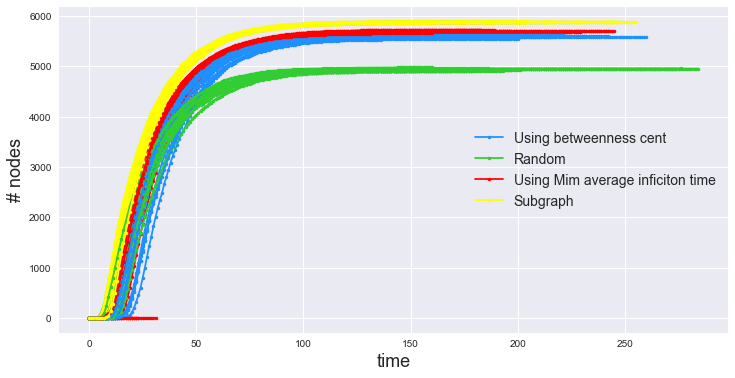

In [121]:
plt.figure(figsize=(12,6))
for _ in range(20):
    SIR_strategy_betweenness_cent = SIRSimulator(g, beta=0.4, mu=0.05, immunization_nodes=maxBC_nodes)
    SIR_random = SIRSimulator(g, beta=0.4, mu=0.05,immunization_factor=M/600)
    SIR_strategy_time = SIRSimulator(g, beta=0.4, mu=0.05, immunization_nodes=minInfictionTime_nodes)
    SIR_subGraph = SIRSimulator(g, beta=0.4, mu=0.05, immunization_nodes=maxDegree_nodes)

    R_strategy_betweenness_cent  = [ (len(status['R'])) for status in SIR_strategy_betweenness_cent.run()]
    R_random  = [ (len(status['R'])) for status in SIR_random.run()]
    R_strategy_time  = [ (len(status['R'])) for status in SIR_strategy_time.run()]
    R_subGraph  = [ (len(status['R'])) for status in SIR_subGraph.run()]

    plt.plot(R_strategy_betweenness_cent, '.-', color = 'dodgerblue')
    plt.plot(R_random, '.-', color = 'limegreen')
    plt.plot(R_strategy_time, '.-', color = 'red')
    plt.plot(R_subGraph, '.-', color = 'yellow')

    plt.xlabel('time', fontsize=18)
    plt.ylabel('# nodes', fontsize=18)
    plt.legend(['Using betweenness cent', 'Random','Using Mim average inficiton time', "Subgraph"], fontsize=14, loc=7)